# Computer Vision - P6

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): December 26, 23:59 h** 

## Haar-like features applied for face detection

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
 - Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

In [1]:
# Some useful imports for the exercises
import numpy as np
import os
from skimage import io
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
from time import time
import timeit
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

%matplotlib inline

**1) Build a function `to_integral_image` that computes the integral image of an input (2D) array.**

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

```python
 def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    # Add here code
    
    return integral_image_arr
```


You can make the following tests:
 
 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 
Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```




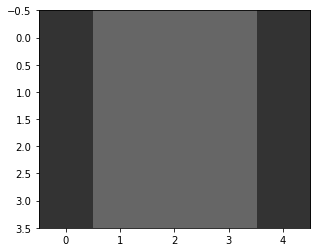

In [2]:
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
img_array.shape
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)

In [3]:
def to_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    
    # Iterate over rows
    for x in range(img_arr.shape[1]):
        # Iterate over cols
        for y in range(img_arr.shape[0]):
            # Sum the preview value and the actual value
            row_sum[y, x] = row_sum[y-1, x] + img_arr[y, x]
            #In the next value we save the value of the next column plus the actual value from row sum
            integral_image_arr[y+1, x+1] = integral_image_arr[y+1, x] + row_sum[y, x]
            
    return integral_image_arr



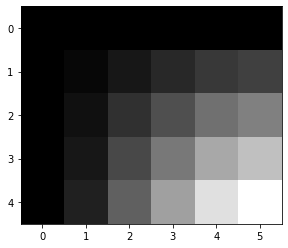

In [4]:
ii_img_array = to_integral_image(img_array)
plt.imshow(ii_img_array, cmap="gray")

**2) Build a function to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.**

Make the function with the following header:
```
def sum_region(integral_img_arr, top_left, bottom_right):
```


In [5]:
def sum_region(integral_img_arr, top_left, bottom_right):
    ### write it!
    # Get points
    top, left = top_left
    bottom, right = bottom_right    
    
    corner_A = integral_img_arr[top, left]
    corner_B = integral_img_arr[top, right]
    corner_C = integral_img_arr[bottom, left]
    corner_D = integral_img_arr[bottom, right]
    
    return corner_D - corner_B - (corner_C - corner_A)        

In [6]:
# result you should get (12)
sum_region(ii_img_array, [1,1],[3,4])

12.0

In [7]:
# result you should get (32)
sum_region(ii_img_array, [0,0],[-1,-1])

32.0

**3) Compute the integral image for all the following images:**
    
- training images of faces: save results in **`faces_ii_training`**
- testing images of face: save the results in **`faces_ii_testing`**
- training images of non faces: **`non_faces_ii_training`**
- testing images of non faces:  **`non_faces_ii_testing`**

To do so build a function to read all the images inside a given folder:

```python
def load_images(path):
    images = []
    for _file in os.listdir(path):
       #### Read image
       #### Remember to scale the image (wih the max pixel intensity value)
     
    return images
 ```

In [11]:
pos_training_path = 'trainingdata/faces'
neg_training_path = 'trainingdata/nonfaces'
pos_testing_path = 'trainingdata/faces/test'
neg_testing_path = 'trainingdata/nonfaces/test'

In [9]:
def load_images(path):
    images = []
    # Iterate over all the files in directory
    for file in os.listdir(path):
        # Only take images end with png
        if file.endswith(".png") :     
            # Get image
            img = io.imread(path + "/" + file)
            # Normalize the image
            img = img  / img.max()
            # Get integral image and save it
            images.append(to_integral_image(img))
    return images

In [10]:
faces_ii_training = load_images(pos_training_path) # Training faces
faces_ii_testing = load_images(pos_testing_path) # Testing faces
non_faces_ii_training = load_images(neg_training_path) # Training no faces
non_faces_ii_testing = load_images(neg_testing_path) # Testing no faces

**4) Compute the Haar features of an image**

The code given will use the  `sum_region` function you have implemented to compute Haar-like features.
The following code, for example, will compute a vertical Haar-like feature
```python
    first = sum_region(int_img, 
                      self.top_left, 
                      (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
    second = sum_region(int_img, 
                       (self.top_left[0], int(self.top_left[1] + self.height / 2)),
                       self.bottom_right)
    score = first - second
```

We provide you with `HaarLikeFeature` class that has build in a `get_score` function and a `get_vote` function.

Your job is to 
```python
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
                
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features
```

In [11]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: violajonse.HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)


In [12]:

def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    :return: List of selected features
    :rtype: list[violajones.HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=None)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')


    return classifiers

def _get_feature_vote(feature, image):
    return feature.get_vote(image)

def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                pass # remove this pass
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features


**5)Use the learn method to learn a list of classifiers with the train data**

With the `learn` function you can build a list of classifiers that detect whether an image contains a face or not.

Use the following hyperparameters of the features and `num_classifiers`.

In [13]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [14]:
%%time 
#classifiers = learn(...)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


**6) Make a function for voting with different classifiers**

Build two functions `ensemble_vote` and `ensemble_vote_all`.

- `ensemble_vote(int_img, classifiers)` has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise

- `ensemble_vote_all(int_imgs, classifiers)` has to loop over the list `int_imgs` and compute the `ensemble_vote` for each image in the list. It has to return a list containing all the votes for all the images in  `int_imgs`.

Use the functions to compute the train and test acurracies for faces and non faces.

Print the results in the following format:
```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [15]:
def ensemble_vote(int_img, classifiers):
    return

In [16]:
# Solution 1
def ensemble_vote_all(int_imgs, classifiers):
    return


**7) Make another test with 20 classifiers instead of 2**

Inspect the classification results if you use adaboost with 20 classifiers. Use the same hyperameters for the features.
Print the results as in the previous exercise:

```
train results:
Correctly identified Faces: 2256/2429  (92.87772745986003%)
Correctly identified non-Faces: 7046/8548  (82.42863827795975%)

test results:
Correctly identified Faces: 285/472  (60.381355932203384%)
Correctly identified non-Faces: 104/128  (81.25%)
```

- Do the classification results improved in the train data?



In [17]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

**8) Change the voting functions so that you can set a threshold for deciding a prediction**

The threshold value indicates the minimum score for assigning a "positive" label (detect a face).

Create the following functions

- `ensemble_vote_t`: returns the final decision of a list of classifiers for a given threshold.
- `ensemble_vote_all_t`: Iterates over a list of integral images and returns the  final decision of a list of classifiers for each of the images (for a given threshold).



compute the following:

- a) number of correct faces over all faces (in the train data)
- b) number of correct non faces over all non faces (in the train data)
- c) number of correct faces over all faces (in the test data)
- d) number of correct non faces over all non faces (in the test data)

Using the list of 20 classifiers.


The quantities have to be computed for each of the following thresholds:

```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

- Make a bar bar plot for a) b) c) and d). In the x axis write the threshold value. 

- What happens when you increase the threshold value ?

In [18]:
thresholds = np.array([x for x in range(-5,5,1)])/10.

In [19]:
correct_faces_train_t = []
correct_non_faces_train_t = []
correct_faces_test_t = []
correct_non_faces_test_t = []

In [20]:
def ensemble_score(int_img, classifiers):
    return sum([c.get_vote(int_img) for c in classifiers])

def ensemble_vote_t(int_img, classifiers,t):
    return

def ensemble_vote_all_t(int_imgs, classifiers,t=-0.1):
    votes = []

    
    return votes


## Face recognition

1. Define an appropiate representation

2. Train a classifier 

3. Recognize a new face example

**1) Build a new reduced space applying a PCA to the faces and non faces images**

Remember we have the following images:

- training images of faces
- testing images of face
- training images of non faces
- testing images of non faces

In [12]:
def load_images_no_integral(path):
    images = []
    # Iterate over all the files in directory
    for file in os.listdir(path):
        # Only take images end with png
        if file.endswith(".png") :     
            # Get image
            img = io.imread(path + "/" + file)            
            # save image
            images.append(img)
    return images

In [13]:
# Loading images
faces_training = load_images_no_integral(pos_training_path) # Training faces
faces_testing = load_images_no_integral(pos_testing_path) # Testing faces
non_faces_training = load_images_no_integral(neg_training_path) # Training no faces
non_faces_testing = load_images_no_integral(neg_testing_path) # Testing no faces

X_train = np.array(faces_training + non_faces_training)
X_test = np.array(faces_testing + non_faces_testing)

y_train = np.array([1] * len(faces_training) + [0] * len(non_faces_training)) # Labels face = 1, non face = 0
y_test = np.array([1] * len(faces_testing) + [0] * len(non_faces_testing)) # Labels face = 1, non face = 0

nsamples, h, w = X_train.shape
print(X_test.shape)
print(h, w)

def reshapeData(data):
    nsamples, h, w = data.shape
    new_data = data.reshape((nsamples,h*w))
    return new_data

# Reshape X_train
X_train = reshapeData(X_train)

# Reshape X_test
X_test = reshapeData(X_test)

(50, 19, 19)
19 19


In [14]:
from sklearn.decomposition import PCA

n_components = 40
# compute PCA
pca = PCA(n_components = n_components).fit(X_train)

# apply tranformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

**2) Train a classifier from a set of example**

Train a adaboost classifier using the new PCA subspace 

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report # to visualize the classification results

# AdaBoostClassifier using the PCA data
ada_model_pca = AdaBoostClassifier(n_estimators=10, random_state=0)
# Fit AdaBoost
ada_model_pca.fit(X_train_pca, y_train)

y_pred_pca = ada_model_pca.predict(X_test_pca)

score_pca = ada_model_pca.score(X_test_pca, y_test)
# Non Face will be 0, Face will be 1
target_names = ['Non Face', 'Face']

print(classification_report(y_test, y_pred_pca, target_names=target_names))

              precision    recall  f1-score   support

    Non Face       0.37      0.80      0.51        20
        Face       0.43      0.10      0.16        30

    accuracy                           0.38        50
   macro avg       0.40      0.45      0.34        50
weighted avg       0.41      0.38      0.30        50



**3) Recognize a new examples**

Proyect the new face examples (test set) in the learned model. Plot the image with the prediction of the model and the real label.

<img src="notebook_images/prediction.png">


In [18]:
# Function will plot all
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    # Struct
    fig = plt.figure(figsize=(10,10))
    
    # Plot every image
    for i in range(rows * cols):
        # Create subplot
        plt.subplot(rows, cols, i + 1)
        # Plot image
        plt.imshow(images[i].reshape((h, w)), cmap='gray')
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
    fig.tight_layout()

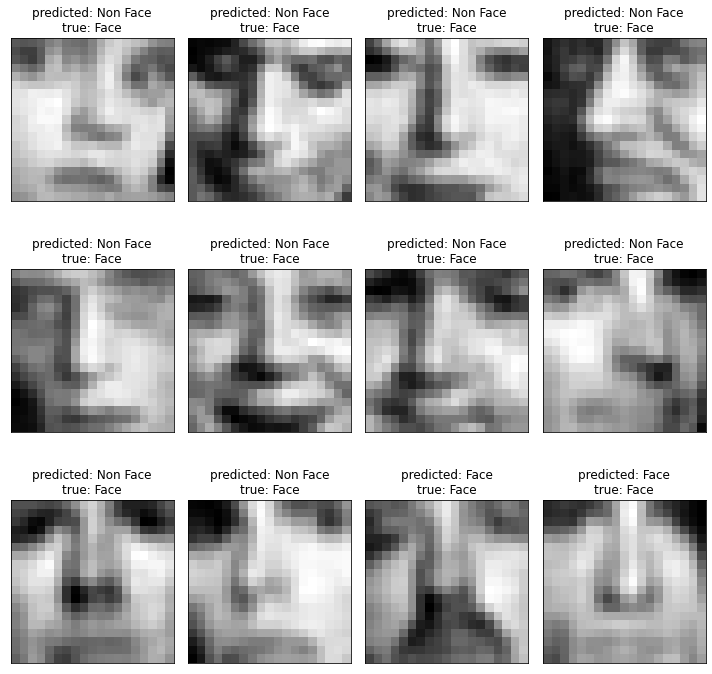

In [22]:
# Save prediction and true label
# Plot the results
def predict(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]]    
        true_name = target_names[y_test[i]]

        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
        
prediction_titles = list(predict(y_pred_pca, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)